# 🎦**AlloCiné Data Analysis**📊

We had web scraped the [movies](https://github.com/Bastien-LDC/Allocine-Recommender-System/blob/master/Webscraping/Webscraping_Movies_From_AlloCine.ipynb), [series](https://github.com/Bastien-LDC/Allocine-Recommender-System/blob/master/Webscraping/Webscraping_Series_From_AlloCine.ipynb), and [ratings](https://github.com/Bastien-LDC/Allocine-Recommender-System/blob/master/Webscraping/Webscraping_Ratings_From_AlloCine.ipynb) data from the [AlloCiné](https://www.allocine.fr/) website.

**Data description :**

Features|Movies|Series|Ratings
-------|---------|---------|---
`id`|X|X|-
`title`|X|X|-
`status`|-|X|-
`release_date`|X|X|-
`duration`|X|X|-
`nb_seasons`|-|X|-
`nb_episodes`|-|X|-
`genres`|X|X|-
`directors`|X|X|-
`actors`|X|X|-
`nationality`|X|X|-
`press_rating`|X|X|X
`nb_press_rating`|X|X|-
`spect_rating`|X|X|X
`nb_spect_rating`|X|X|-
`summary`|X|X|-
`poster_link`|X|X|-
`user_id`|-|-|X
`(user/press)_name`|-|-|X
`(movie/series)_id`|-|-|X
`date`|-|-|X


If you are interested in, the data is available on one csv (brut and clean version) [allocine_dataset.zip](http://olivier-maillot.fr/wp-content/uploads/2017/08/allocine_dataset.zip) or in multiple csv files (clean version only) [allocine_rel-dataset.zip](http://olivier-maillot.fr/wp-content/uploads/2017/08/allocine_rel-dataset.zip).

---
# **Data cleaning**

In [100]:
# import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os


%matplotlib inline

In [101]:
# Load the csv
def load_csv():
    '''
    Load the csv file and return a dataframe
    '''
    root_path = "../Saved Data/"
    movies = pd.read_csv(f"{root_path}allocine_movies_100p.csv")
    series = pd.read_csv(f"{root_path}allocine_series_100p.csv")
    press_movies = pd.read_csv(f"{root_path}press_ratings_movies.csv")
    press_series = pd.read_csv(f"{root_path}press_ratings_series.csv")
    user_movies = pd.read_csv(f"{root_path}user_ratings_movies.csv")
    user_series = pd.read_csv(f"{root_path}user_ratings_series.csv")
    return {"movies":movies, "series":series, "press_movies":press_movies, "press_series":press_series, "user_movies":user_movies, "user_series":user_series}
data = load_csv()
movies, series, press_movies, press_series, user_movies, user_series = data["movies"], data["series"], data["press_movies"], data["press_series"], data["user_movies"], data["user_series"]

In [102]:
# Rename (nb_)spec_rating to (nb_)user_rating
movies.rename(columns={'spect_rating':'user_rating', 'nb_spect_rating':'nb_user_rating'}, inplace=True)
series.rename(columns={'spect_rating':'user_rating', 'nb_spect_rating':'nb_user_rating'}, inplace=True)

In [103]:
# Store columns names
movies_cols = movies.columns
series_cols = series.columns
press_movies_cols = press_movies.columns
press_series_cols = press_series.columns
user_movies_cols = user_movies.columns
user_series_cols = user_series.columns

In [104]:
# Convert the strings to arrays
def convert_to_array(df: pd.DataFrame):
    '''
    Convert the strings to arrays
    '''
    df["genres"] = df["genres"].apply(lambda x: x.split(",") if type(x) not in [float,list] else x)
    df["directors"] = df["directors"].apply(lambda x: x.split(",") if type(x) not in [float,list] else x)
    df["actors"] = df["actors"].apply(lambda x: x.split(",") if type(x) not in [float,list] else x)
    df["nationality"] = df["nationality"].apply(lambda x: x.split(",") if type(x) not in [float,list] else x)

In [105]:
convert_to_array(movies)
convert_to_array(series)
# Convert nb_spec_rating and nb_press_rating to int
#movies[["nb_press_rating","nb_user_rating"]] = movies[["nb_press_rating","nb_user_rating"]].astype(int)
#series[["nb_press_rating","nb_user_rating"]] = series[["nb_press_rating","nb_user_rating"]].astype(int)

In [106]:
# Get keys from values in dictionnary
def get_keys(val):
    '''
    Get keys from values in dictionnary
    '''
    return list(val.keys())

In [107]:
def display_stats(df: pd.DataFrame):
    '''
    Display the statistics of a dataframe
    '''
    # Graph of number of missing values by column
    missing_values = df.isnull().sum()
    if missing_values.sum() > 0:      
        missing_values = missing_values / df.shape[0] * 100
        missing_values = missing_values[missing_values > 0]
        missing_values.sort_values(inplace=True)
        plt.figure(figsize=(12, 5))
        plt.title(f"Number of missing values in each column")
        sns.barplot(x=missing_values.index, y=missing_values)
        plt.show()
    else:
        print("No missing values in the dataframe")
    df.info()
    return df.describe()

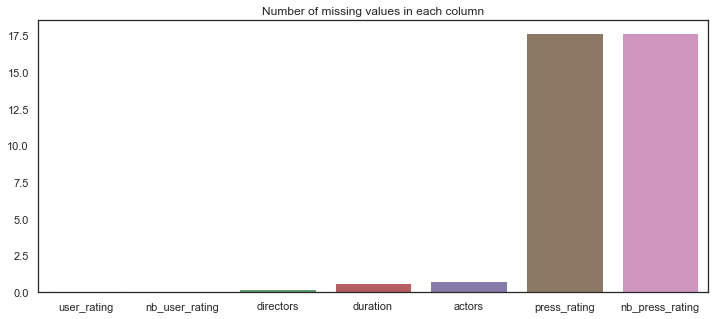

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1314 entries, 0 to 1313
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   id               1314 non-null   int64  
 1   title            1314 non-null   object 
 2   release_date     1314 non-null   object 
 3   duration         1306 non-null   float64
 4   genres           1314 non-null   object 
 5   directors        1311 non-null   object 
 6   actors           1304 non-null   object 
 7   nationality      1314 non-null   object 
 8   press_rating     1082 non-null   float64
 9   nb_press_rating  1082 non-null   float64
 10  user_rating      1313 non-null   float64
 11  nb_user_rating   1313 non-null   float64
 12  summary          1314 non-null   object 
 13  poster_link      1314 non-null   object 
dtypes: float64(5), int64(1), object(8)
memory usage: 143.8+ KB


,id,duration,press_rating,nb_press_rating,user_rating,nb_user_rating
count,1314.000000,1306.000000,1082.000000,1082.000000,1313.000000,1313.000000
mean,190412.920852,114.133997,3.368669,20.210721,3.393222,12183.638233
std,100371.378919,22.899272,0.671301,9.405942,0.725331,20182.985813
min,62.000000,40.000000,1.000000,1.000000,0.900000,2.000000
25%,114985.500000,98.000000,2.900000,13.000000,2.900000,605.000000
50%,231904.000000,110.000000,3.400000,21.000000,3.500000,3518.000000
75%,274180.250000,126.000000,3.800000,27.000000,4.000000,15259.000000
max,303108.000000,242.000000,5.000000,45.000000,4.600000,175729.000000


In [108]:
m_stats = display_stats(movies)
m_stats

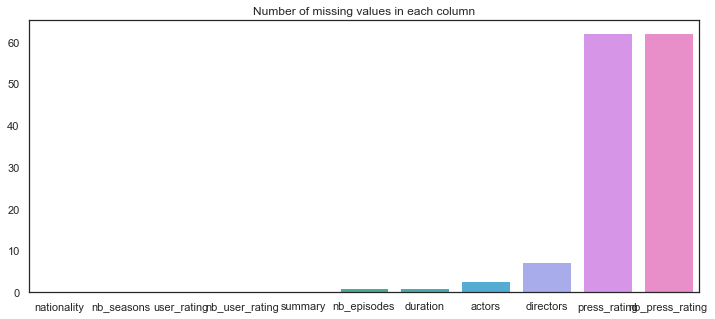

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1417 entries, 0 to 1416
Data columns (total 17 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   id               1417 non-null   int64  
 1   title            1417 non-null   object 
 2   status           1417 non-null   object 
 3   release_date     1417 non-null   object 
 4   duration         1402 non-null   float64
 5   nb_seasons       1412 non-null   float64
 6   nb_episodes      1403 non-null   float64
 7   genres           1417 non-null   object 
 8   directors        1314 non-null   object 
 9   actors           1380 non-null   object 
 10  nationality      1416 non-null   object 
 11  press_rating     538 non-null    float64
 12  nb_press_rating  538 non-null    float64
 13  user_rating      1412 non-null   float64
 14  nb_user_rating   1412 non-null   float64
 15  summary          1412 non-null   object 
 16  poster_link      1417 non-null   object 
dtypes: float64(7),

,id,duration,nb_seasons,nb_episodes,press_rating,nb_press_rating,user_rating,nb_user_rating
count,1417.000000,1402.000000,1412.000000,1403.000000,538.000000,538.000000,1412.000000,1412.000000
mean,18410.076923,45.589872,3.462465,56.213115,3.320260,8.423792,3.582861,3858.217422
std,9185.343923,15.212255,3.973424,160.353704,0.598803,3.749457,0.607539,12297.334603
min,4.000000,3.000000,1.000000,1.000000,1.300000,1.000000,0.900000,1.000000
25%,11146.000000,42.000000,1.000000,10.000000,2.900000,6.000000,3.300000,126.000000
50%,21842.000000,45.000000,2.000000,20.000000,3.300000,8.000000,3.700000,482.000000
75%,25149.000000,55.000000,4.000000,52.000000,3.800000,10.000000,4.000000,2090.500000
max,31644.000000,150.000000,52.000000,4573.000000,5.000000,30.000000,4.700000,205979.000000


In [109]:
s_stats = display_stats(series)
s_stats

In [110]:
pm_stats = display_stats(press_movies)
pm_stats

No missing values in the dataframe
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21582 entries, 0 to 21581
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   press_name    21582 non-null  object 
 1   movie_id      21582 non-null  int64  
 2   press_rating  21582 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 506.0+ KB


,movie_id,press_rating
count,21582.000000,21582.000000
mean,200088.014920,3.446159
std,85667.022665,1.097436
min,62.000000,1.000000
25%,135082.000000,3.000000
50%,230868.000000,4.000000
75%,269758.000000,4.000000
max,299394.000000,5.000000


In [111]:
ps_stats = display_stats(press_series)
ps_stats

No missing values in the dataframe
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4516 entries, 0 to 4515
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   press_name    4516 non-null   object 
 1   series_id     4516 non-null   int64  
 2   press_rating  4516 non-null   float64
dtypes: float64(1), int64(1), object(1)
memory usage: 106.0+ KB


,series_id,press_rating
count,4516.00000,4516.000000
mean,19829.66519,3.379650
std,6495.73654,0.951869
min,49.00000,0.500000
25%,17464.00000,3.000000
50%,22019.00000,3.500000
75%,24397.00000,4.000000
max,30429.00000,5.000000


In [112]:
um_stats = display_stats(user_movies)
um_stats

No missing values in the dataframe
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 105711 entries, 0 to 105710
Data columns (total 5 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   user_id      105711 non-null  object 
 1   user_name    105711 non-null  object 
 2   movie_id     105711 non-null  int64  
 3   user_rating  105711 non-null  float64
 4   date         105711 non-null  object 
dtypes: float64(1), int64(1), object(3)
memory usage: 4.0+ MB


,movie_id,user_rating
count,105711.000000,105711.000000
mean,177012.461220,3.302168
std,98340.085009,1.170735
min,62.000000,0.500000
25%,61764.000000,2.500000
50%,218229.000000,3.500000
75%,263209.000000,4.000000
max,302945.000000,5.000000


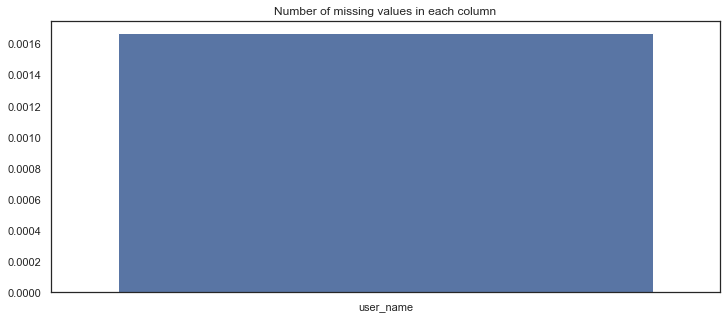

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60031 entries, 0 to 60030
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   user_id      60031 non-null  object 
 1   user_name    60030 non-null  object 
 2   series_id    60031 non-null  int64  
 3   user_rating  60031 non-null  float64
 4   date         60031 non-null  object 
dtypes: float64(1), int64(1), object(3)
memory usage: 2.3+ MB


,series_id,user_rating
count,60031.000000,60031.000000
mean,15515.704053,3.584356
std,9351.003920,1.421383
min,4.000000,0.500000
25%,7634.000000,2.500000
50%,18752.000000,4.000000
75%,23563.000000,5.000000
max,31644.000000,5.000000


In [113]:
us_stats = display_stats(user_series)
us_stats

## **Save Cleaned datasets**

In [99]:
# Save all the dataframes from data in a csv file
def save_data(df: pd.DataFrame, path:str, name: str):
    df.to_csv(f"{path}{name}.csv", index=False)

path = "../Cleaned Data/"
# We create the folder if not exists
os.makedirs(os.path.dirname(path), exist_ok=True)
for k,v in data.items():
    save_data(v, path, k)

# **Section 1. Ratings Distributions**

## Plot the Distribution of Ratings 

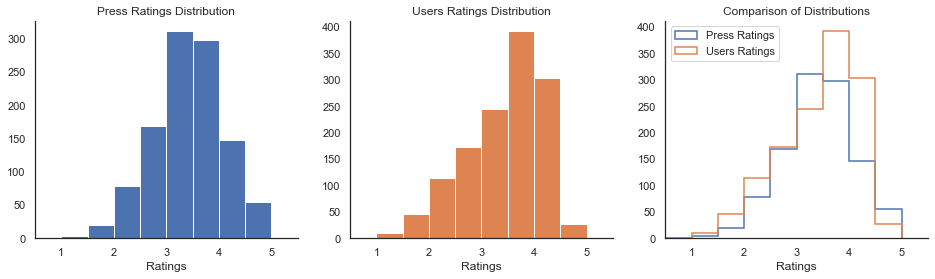

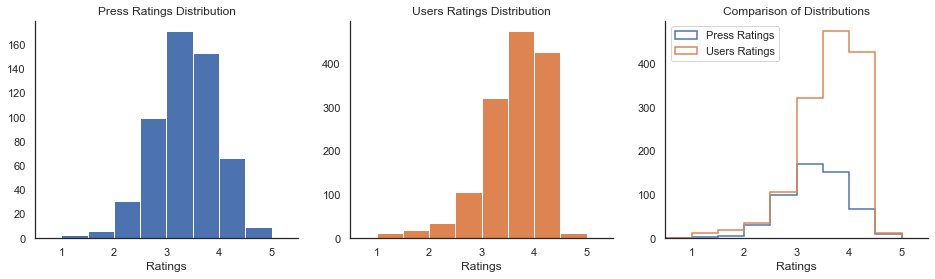

In [72]:
for df in data[:2]:
    sns.set(style="white", palette="deep")

    fig, axes = plt.subplots(1, 3, figsize = (16,4))
    ax1, ax2, ax3 = fig.axes

    ax1.set_xlim([0.5,5.5])
    ax2.set_xlim([0.5,5.5])
    ax3.set_xlim([0.5,5.5])


    ax1.hist(df["press_rating"], bins = 10, range = (0,5), color='C0') # bin range = 1
    ax1.set_title('Press Ratings Distribution')
    ax1.set_xlabel('Ratings')

    ax2.hist(df["user_rating"], bins = 10, range = (0,5), color='C1') # bin range = 1
    ax2.set_title('Users Ratings Distribution')
    ax2.set_xlabel('Ratings')

    ax3.hist(df["press_rating"], bins = 10, range = (0,5), histtype = 'step', 
            lw=1.5, label='Press Ratings', color='C0')
    ax3.hist(df["user_rating"], bins = 10, range = (0,5), histtype = 'step', 
            lw=1.5, label='Users Ratings', color='C1')
    ax3.legend(loc = 'upper left')
    ax3.set_title('Comparison of Distributions')
    ax3.set_xlabel('Ratings')

    for ax in fig.axes:
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)

In [73]:
# save the fig
fig.savefig('allocine-0_hist.png', bbox_inches='tight', dpi=200)

## Ratings Correlation

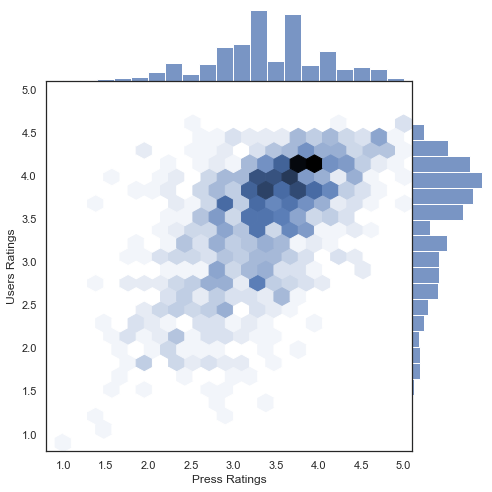

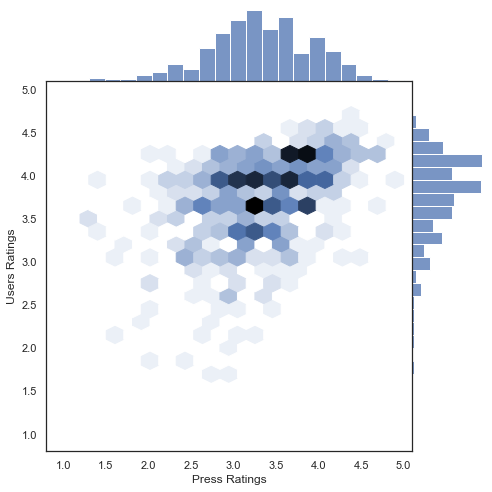

In [74]:
# Correlation between press_rating and user_rating
for df in data[:2]:
    ax = sns.jointplot(x="press_rating", y="user_rating", 
                    data=df, kind="hex",
                    marginal_kws=dict(bins=20),
                    xlim=(0.8,5.1), ylim=(0.8,5.1),
                    height=7, space=0).set_axis_labels("Press Ratings", "Users Ratings")

In [ ]:
# save the fig
ax.savefig('allocine-1_jointplot.png', bbox_inches='tight', dpi=200)

# **Section 2. Five Stars Movies Analysis**

The press seems to give much more hightest ratings than AlloCiné users. We need to dig a little bit more to see what happening here. In this section we use a subset of the data where press ratings are five stars. 

## Compare to users ratings

In [ ]:
five_stars = allocine[allocine["press_rating"] >= 5]
f, ax = plt.subplots(figsize=(15,6))
f.suptitle('Movies with Five Stars From The Press', 
           fontsize=13)
f.subplots_adjust(top=0.85)

sns.countplot(x=five_stars["user_rating"], ax=ax)
ax.set_xlabel("Users Ratings")
ax.set_ylabel("")
sns.despine(top=True, right=True, left=False, bottom=False)

In [ ]:
# save the fig
f.savefig('allocine-2_hist5stars.png', bbox_inches='tight', dpi=200)

In [ ]:
# print the first tier and second tier of the Users Ratings
allocine[["user_rating"]].quantile([.33,.66])

In [ ]:
p = (len(five_stars[(five_stars["user_rating"] < 2.9)]) / len(five_stars)) * 100
print('{} % of the movies with the highest press ratings received a low users ratings.'.format(round(p, 2)))
p = (len(five_stars[(five_stars["user_rating"] < 3.4) & (five_stars["user_rating"] >= 2.9)]) / len(five_stars)) * 100
print('{} % of the movies with the highest press ratings received a moderate users ratings.'.format(round(p, 2)))
p = (len(five_stars[five_stars["user_rating"] >= 3.4]) / len(five_stars)) * 100
print('{} % of the movies with the highest press ratings received a high users ratings.'.format(round(p, 2)))

# **Section 3. Data Exploration**

## **GENRE**

### Number of movies per genre

#### *Get all genres*

In [85]:
# Get all unique m_genres from list of m_genres
m_genres, s_genres = [genre.lstrip() for m_genres in movies["genres"] for genre in m_genres], [genre.lstrip() for m_genres in series["genres"] for genre in m_genres]
m_genres, s_genres = sorted(list(set(m_genres))), sorted(list(set(s_genres)))
print(m_genres),print(s_genres)
m_genres == s_genres

['Action', 'Animation', 'Arts Martiaux', 'Aventure', 'Biopic', 'Comédie', 'Comédie dramatique', 'Comédie musicale', 'Drame', 'Epouvante-horreur', 'Erotique', 'Espionnage', 'Famille', 'Fantastique', 'Guerre', 'Historique', 'Judiciaire', 'Musical', 'Policier', 'Péplum', 'Romance', 'Science fiction', 'Sport event', 'Thriller', 'Western']
['Action', 'Animation', 'Arts Martiaux', 'Aventure', 'Biopic', 'Comédie', 'Comédie dramatique', 'Comédie musicale', 'Dessin animé', 'Documentaire', 'Drame', 'Epouvante-horreur', 'Erotique', 'Espionnage', 'Famille', 'Fantastique', 'Guerre', 'Historique', 'Judiciaire', 'Musical', 'Médical', 'Policier', 'Péplum', 'Romance', 'Science fiction', 'Show', 'Soap', 'Sport event', 'Thriller', 'Websérie', 'Western']


False

#### *Create a `genre` dataframe*

In [ ]:
# Create dataframe with the number of movies per genre from genre list
genre_df = pd.DataFrame({"genre": genres, "nb_movies": [allocine[allocine["genres"].apply(lambda x: genre in x).values].shape[0] for genre in genres]})

# Add the nb_press_rating and nb_user_rating to the genre_df
genre_df["nb_press_rating"] = [allocine[allocine["genres"].apply(lambda x: genre in x).values]["nb_press_rating"].sum() for genre in genres]
genre_df["nb_user_rating"] = [allocine[allocine["genres"].apply(lambda x: genre in x).values]["nb_user_rating"].sum() for genre in genres]

# Add the total_ rating to the genre_df (press_rating + user_rating)
genre_df["total_rating"] = genre_df["nb_press_rating"] + genre_df["nb_user_rating"]

# Add the press_rating_percentage and user_rating_percentage to the genre_df 
genre_df["press_rating_percentage"] = round(genre_df["nb_press_rating"] / genre_df["nb_press_rating"].values.sum() * 100, 2)
genre_df["user_rating_percentage"] = round(genre_df["nb_user_rating"] / genre_df["nb_user_rating"].values.sum() * 100, 2)

# Add the movie_percentage to the genre_df
genre_df["movie_percentage"] = round(genre_df["nb_movies"]/nb_movies * 100, 2)
genre_df

In [ ]:
# Hist of the percentage of movies per genre
ax = sns.barplot(x="genre", y="movie_percentage", data=genre_df, color="C2")
ax.set_title("Percentage of movies per genre")
ax.set_xlabel("Genre")
ax.set_ylabel("Percentage of movies")

# Pretty print x axis names
for i, genre in enumerate(ax.get_xticklabels()):
    genre.set_rotation(90)
    genre.set_horizontalalignment('center')
    genre.set_position((i, 0))

# Print the data values on top of the bars
for i, genre in enumerate(ax.patches):
    ax.text(genre.get_x() + genre.get_width()/2.,
            genre.get_height() + 0.5,
            str(genre_df.iloc[i]["movie_percentage"]) + "%",
            ha='center',
            color='black',
            fontsize=10)

In [ ]:
# Hist of the percentage of press_rating per genre
ax = sns.barplot(x="genre", y="press_rating_percentage", data=genre_df, color="C0")
ax.set_title("Percentage of press_rating per genre")
ax.set_xlabel("Genre")
ax.set_ylabel("Percentage of press_rating")

# Pretty print x axis names
for i, genre in enumerate(ax.get_xticklabels()):
    genre.set_rotation(90)
    genre.set_horizontalalignment('center')
    genre.set_position((i, 0))

In [ ]:
# Hist of the percentage of user_rating per genre
ax = sns.barplot(x="genre", y="user_rating_percentage", data=genre_df, color="C1")
ax.set_title("Percentage of user_rating per genre")
ax.set_xlabel("Genre")
ax.set_ylabel("Percentage of user_rating")

# Pretty print x axis names
for i, genre in enumerate(ax.get_xticklabels()):
    genre.set_rotation(90)
    genre.set_horizontalalignment('center')
    genre.set_position((i, 0))

### Number of ratings per genre

### Average ratings per genre

## **NATIONALITY**

In [ ]:
# Get all unique nationalities from list of nationalities
nationality = [nat.lstrip() for nationality in movies["nationality"] for nat in nationality]
nationality = sorted(list(set(nationality)))
nationality